In [48]:
import cv2
import glob
import matplotlib.pyplot as plt
import cv2.aruco as aruco
import numpy as np

# https://docs.opencv.org/4.7.0/df/d4a/tutorial_charuco_detection.html - jest do niczego
# opencv 4.7.0 - wszystko na nim robię

In [74]:
RELATIVE_PATH = "./chessboard_photos_for_calibration/images_of_charuco_second_attempt_realsense/*.jpg"
ROW_COUNT = 7
COLUMN_COUNT = 5
SIZE_FULL_SQUARE =  0.0285
SIZE_SQUARE = 0.023
IMG_SIZE  = (1280,720)

images = sorted(glob.glob(RELATIVE_PATH))
dictionary = aruco.getPredefinedDictionary(aruco.DICT_4X4_250)

img_points = []
corners_all = []
good_images = []
for iname in images:
    img = cv2.imread(iname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    board = aruco.CharucoBoard((ROW_COUNT, COLUMN_COUNT), SIZE_FULL_SQUARE, SIZE_SQUARE, dictionary)
    
    detector = aruco.CharucoDetector(board)
    charuco_corners, charuco_ids, marker_corners, marker_ids = detector.detectBoard(
            image = gray)

    if charuco_corners is None:
        print("Didn't find board on ", iname)
        continue
        
    charuco_ids_flat = list(np.concatenate(charuco_ids).flat)

    img = aruco.drawDetectedMarkers(
            image = img, 
            corners = marker_corners)

    img = aruco.drawDetectedCornersCharuco(
            image = img,
            charucoCorners = charuco_corners,
            charucoIds = charuco_ids)

    counter = (ROW_COUNT - 1) * (COLUMN_COUNT -1 ) - 4
    if len(charuco_corners) > counter:
        good_images.append(iname)
        img_points.append(charuco_corners)
        #assert tuple(charuco_ids) == tuple([[i] for i in range(counter)])
        corners_all.append(np.matrix([board.getChessboardCorners()[i] for i in charuco_ids_flat]))
    else:
        print("There wasn't enough charuco corners on ", iname)

There wasn't enough charuco corners on  ./chessboard_photos_for_calibration/images_of_charuco_second_attempt_realsense/photo_0_2023-03-15.jpg
There wasn't enough charuco corners on  ./chessboard_photos_for_calibration/images_of_charuco_second_attempt_realsense/photo_100_2023-03-15.jpg
There wasn't enough charuco corners on  ./chessboard_photos_for_calibration/images_of_charuco_second_attempt_realsense/photo_101_2023-03-15.jpg
There wasn't enough charuco corners on  ./chessboard_photos_for_calibration/images_of_charuco_second_attempt_realsense/photo_102_2023-03-15.jpg
There wasn't enough charuco corners on  ./chessboard_photos_for_calibration/images_of_charuco_second_attempt_realsense/photo_103_2023-03-15.jpg
There wasn't enough charuco corners on  ./chessboard_photos_for_calibration/images_of_charuco_second_attempt_realsense/photo_104_2023-03-15.jpg
There wasn't enough charuco corners on  ./chessboard_photos_for_calibration/images_of_charuco_second_attempt_realsense/photo_105_2023-03-1

In [75]:
calibration, cameraMatrix, distCoeffs, rvecs, tvecs = cv2.calibrateCamera(
        objectPoints = corners_all,
        imagePoints = img_points,
        imageSize = IMG_SIZE,
        cameraMatrix = None,
        distCoeffs = None)


In [76]:
print(calibration)
print(cameraMatrix)
print(distCoeffs)
#print(rvecs)
#print(tvecs)

77.74928194339068
[[2.80244602e+04 0.00000000e+00 8.98963806e+02]
 [0.00000000e+00 1.19956856e+04 2.37507169e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[-1.31922489e+02  6.99997745e+03  2.31750359e+00 -2.83292094e+00
  -2.20190470e+03]]


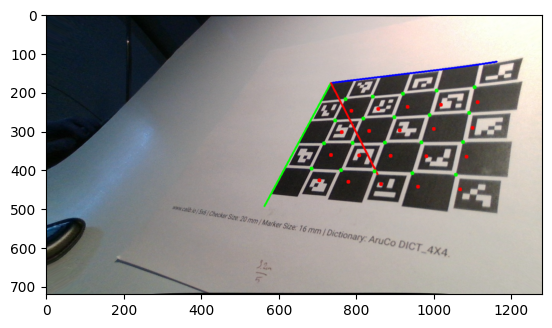

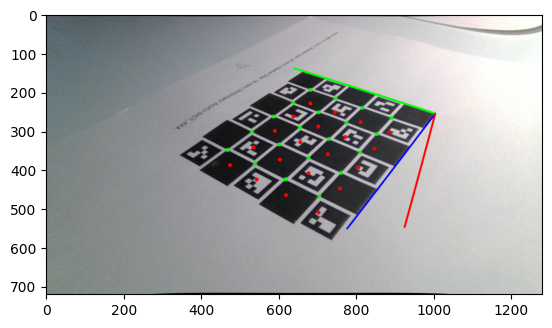

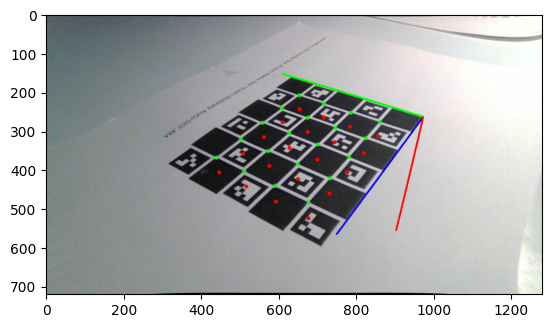

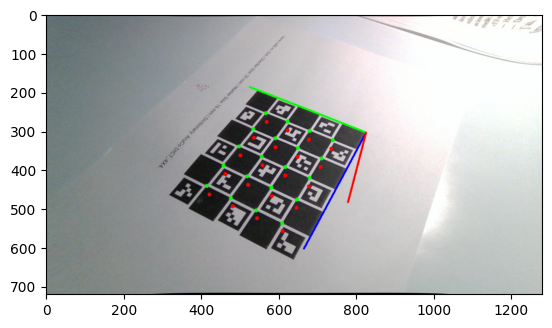

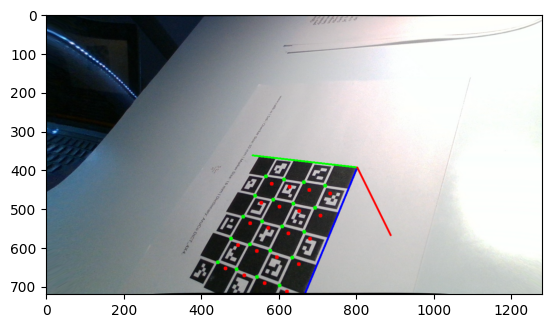

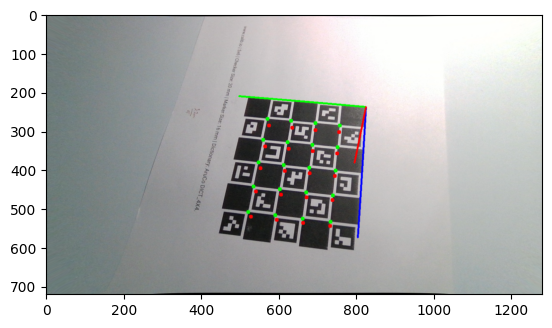

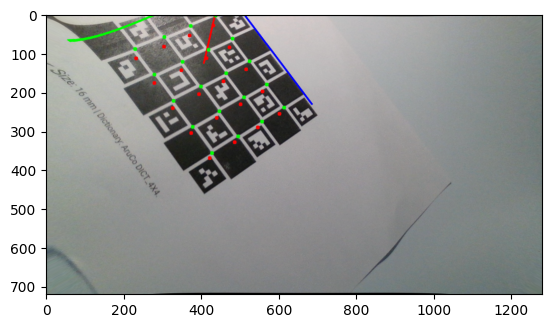

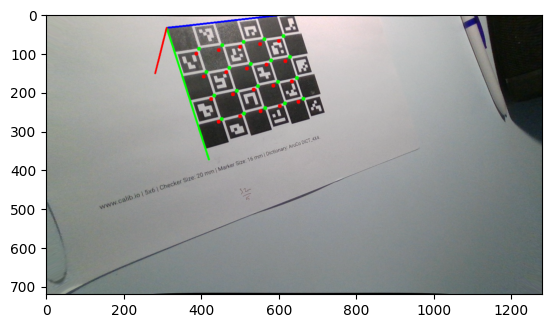

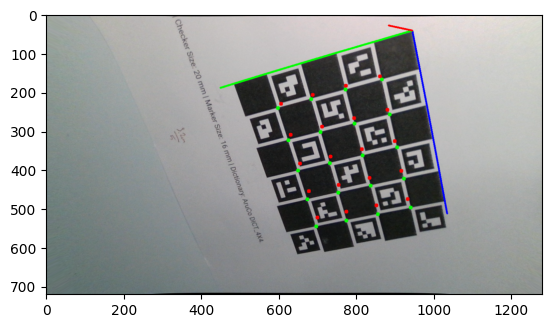

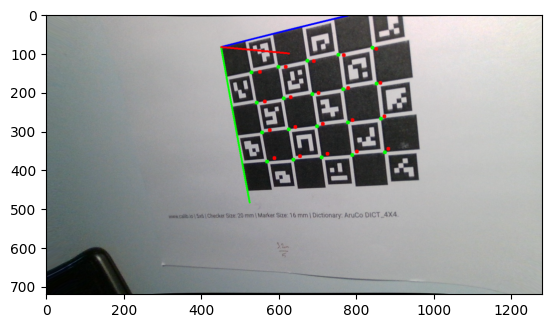

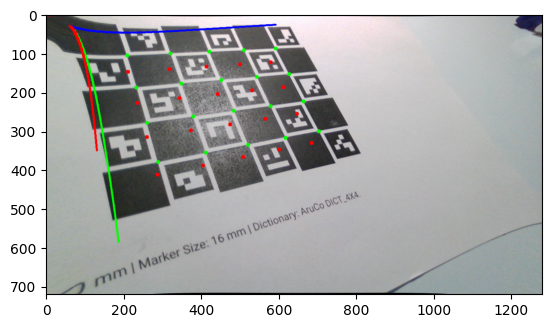

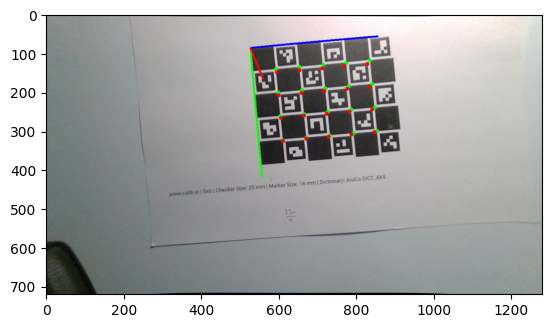

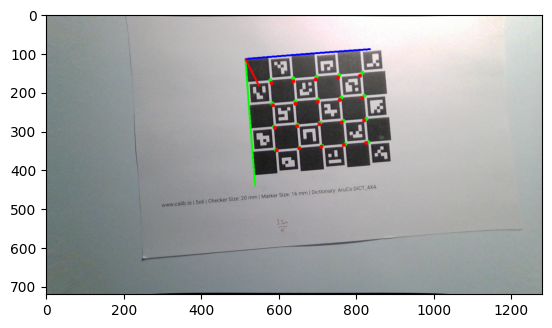

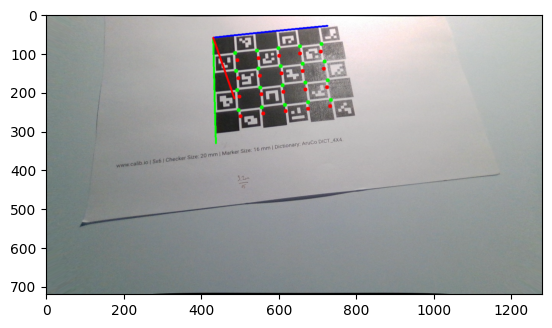

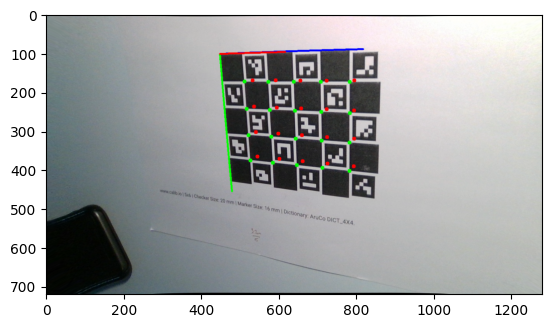

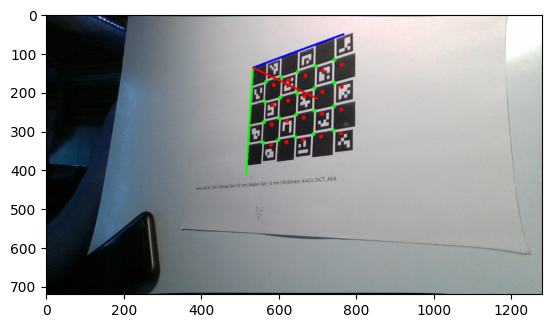

In [66]:
points3D = board.getChessboardCorners() # coordinates of the chessboard corners in the chessboard coordinate system
points3Da = points3D + [[0, 0, 0.01]]   # like points3D, but with a point 1cm under the chessboard
for i in range(len(good_images)):
    tvec = tvecs[i]
    rvec = rvecs[i]
    img = cv2.imread(good_images[i])
    img = cv2.drawFrameAxes(img, cameraMatrix, distCoeffs, rvec, tvec, 0.1) # draw the chessboard coordinate system
    
    # draw green corners on the chessboard
    p = cv2.projectPoints(points3D, rvec, tvec, cameraMatrix, distCoeffs)[0]
    for x, y in p[:,0,:]:
        img = cv2.circle(img, (round(x), round(y)), radius=5, color=(0, 255, 0), thickness=-1)
    
    # draw red corners under the chessboard
    p = cv2.projectPoints(points3Da, rvec, tvec, cameraMatrix, distCoeffs)[0]
    for x, y in p[:,0,:]:
        img = cv2.circle(img, (round(x), round(y)), radius=5, color=(255, 0, 0), thickness=-1)
    
    img = cv2.undistort(img, cameraMatrix, distCoeffs, None, cameraMatrix) # undistort the image (get's crazy)
    
    plt.imshow(img)
    plt.show()